In [81]:
import numpy as np

import cvxpy as cp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import opt
import robustAR_opt
from data import pert_S

In [82]:
def error_metrics(Y_hat, Y_test, H=None, H_gt=None, print_results=True):
    # Normalized error
    if Y_test.ndim == 2:
        norm_y = (Y_test**2).sum(1)#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum(1) / norm_y)
    else:
        norm_y = (Y_test**2).sum((1,2))#np.sqrt((Y_test**2).sum(1))
        err_y = np.mean(((Y_test - Y_hat)**2).sum((1,2)) / norm_y)
    
    if print_results:
        print(f"Error in signal y: {err_y}")

    if H is not None and H_gt is not None:
        # Error wrt ground truth filter
        if H.ndim == 3: # Several filters
            norm_H = (H_gt**2).sum((1,2))
            err_H = np.mean(((H - H_gt)**2).sum((1,2)) / norm_H)
        else:
            norm_H = (H_gt**2).sum()
            err_H = ((H - H_gt)**2).sum() / norm_H

        if print_results:
            print(f"Error in filter: {err_H}")
        return err_y, err_H

    return err_y

In [83]:
def plot_filters(Hs):
    if Hs.ndim == 3:
        n_filt = Hs.shape[0]
    else:
        n_filt = 1
    f, ax = plt.subplots(1, n_filt, figsize=(12,8))

    if n_filt > 1:
        for i in range(n_filt):    
            ax[i].imshow(Hs[i,:,:])
    else:
        ax.imshow(Hs)

# Parameters

In [84]:
pert_graph = False
mean_std_norm = False
norm_data = False
diff = False
monthly_mean = False
n_steps = 1
train_test_split = 0.5
random_train_test = False
P = 2

# Reading the data

In [85]:
#data = np.load('data_temp/temperatures2003_mod_knn8_N40.npz')
#data = np.load('data_temp/temperatures2018_knn8_N28.npz') # 54 or 28 for only valid values, 36 for invalid values as well
#data = np.load('data_temp/temperatures2018_knn5_N31.npz')
data = np.load('data_temp/temperatures2017-18_knn5_N19.npz')

In [86]:
A = data['A_bin']

if pert_graph:
    A = pert_S(A, eps=0.1) # Using default parameters rewire 10% of total links

norm_A = np.sqrt((A**2).sum())

In [87]:
temp_info = data['temps'] # data['X']

if mean_std_norm:
    temp_info -= np.mean(temp_info, 1)[:,None]
    temp_info /= np.std(temp_info, 1)[:,None]

if diff:
    temp_info = np.diff(temp_info, axis=1) / temp_info[:,:1]

if norm_data:
    temp_info = temp_info / np.sqrt((temp_info**2).sum(1))[:,None]

if monthly_mean:
    n_days = 30

    def moving_average(a, n=2) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    month_mean = np.apply_along_axis(moving_average, 1, temp_info, n_days)
    month_mean_padded = np.pad(month_mean, [(0,0), (n_days-1,0)], 'edge')
    assert month_mean_padded.shape == temp_info.shape, "Something went wrong calculating rolling mean"

    temp_info -= month_mean_padded

In [88]:
Y = temp_info[:,n_steps:].copy()
X = temp_info[:,:-n_steps].copy()
N, N_dates = X.shape

In [89]:
if random_train_test:
    idxs = np.random.permutation(N_dates)
else:
    idxs = np.arange(N_dates)

idxs_train = idxs[:int(train_test_split*N_dates)]
idxs_test = idxs[int(train_test_split*N_dates):]

X_train = X[:,idxs_train]
Y_train = Y[:,idxs_train]
X_test = X[:,idxs_test]
Y_test = Y[:,idxs_test]
X_train.shape, Y_train.shape, X_test.shape, N_dates

((19, 364), (19, 364), (19, 365), 729)

In [90]:
Xs = np.array([temp_info[:,p:-(n_steps-1)-P+p] for p in range(P)])
Y_mult = temp_info[:,P+(n_steps-1):]
N_dates_mult = Y_mult.shape[1]
Xs.shape, Y_mult.shape
idxs_mult = idxs.copy() # Using same split as in the previous cases, but needs to be adapted
for p in range(0,P): # Deleting invalid occurrences for this case
    idxs_mult = idxs_mult[idxs_mult != p]
idxs_mult -= (P-1)
assert max(idxs_mult) == N_dates_mult - 1

idxs_train = idxs_mult[:int(train_test_split*N_dates_mult)]
idxs_test = idxs_mult[int(train_test_split*N_dates_mult):]
Xs_train = Xs[:,:,idxs_train]
Xs_test = Xs[:,:,idxs_test]
Y_mult_train = Y_mult[:,idxs_train]
Y_mult_test = Y_mult[:,idxs_test]

# Models

In [91]:
models = []
errs_y = []
errs_H = []

In [92]:
# Ground truth obtained using Least squares over all samples
H = cp.Variable((N,N))
obj = cp.sum_squares(Y_test - H @ X_test)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
H_gt = H.value

In [93]:
y_ls_perf = H_gt @ X_test
err_ls_per, err_H_ls_per = error_metrics(y_ls_perf, Y_test, H_gt, H_gt)
models.append("LS-Perfect (LB)"); errs_y.append(err_ls_per)

Error in signal y: 0.002432455231403666
Error in filter: 0.0


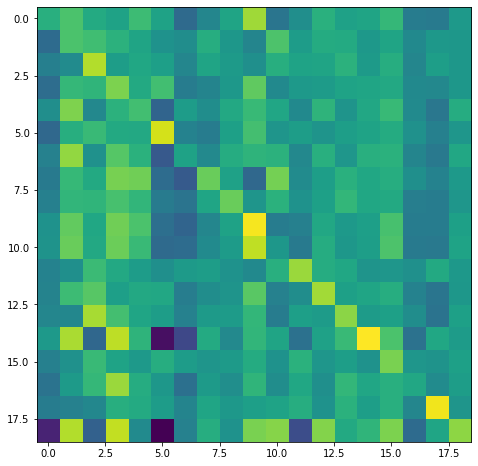

In [94]:
plot_filters(H_gt)

## Toy models for comparison

In [95]:
Y_random = Y_test.std(1)[:,None] * np.random.randn(*Y_test.shape) + Y_test.mean(1)[:,None]
err_random = error_metrics(Y_random, Y_test)
#models.append("Random Return"); errs_y.append(err_random)

Error in signal y: 0.04945992783630078


In [96]:
Y_zeros = np.zeros(Y_test.shape)
err_zeros = error_metrics(Y_zeros, Y_test)
#models.append("Zero Return"); errs_y.append(err_zeros)

Error in signal y: 1.0


In [97]:
# Identity - copying the temperature from the previous day
H_eye = np.eye(N)
Y_eye = H_eye @ X_test
err_eye = error_metrics(Y_eye, Y_test)
models.append("Copy Prev Day"); errs_y.append(err_eye)

Error in signal y: 0.003128289310694482


## Least squares

In [98]:
# Least squares
H = cp.Variable((N,N))#, symmetric=True)
obj = cp.sum_squares(Y_train - H @ X_train)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
H_ls = H.value

In [99]:
Y_hat_ls = H_ls @ X_test
err_y_ls, err_H_ls = error_metrics(Y_hat_ls, Y_test, H_ls, H_gt)
models.append("Least Squares"); errs_y.append(err_y_ls); errs_H.append(err_H_ls)

Error in signal y: 0.002930381748919494
Error in filter: 0.8678883590507872


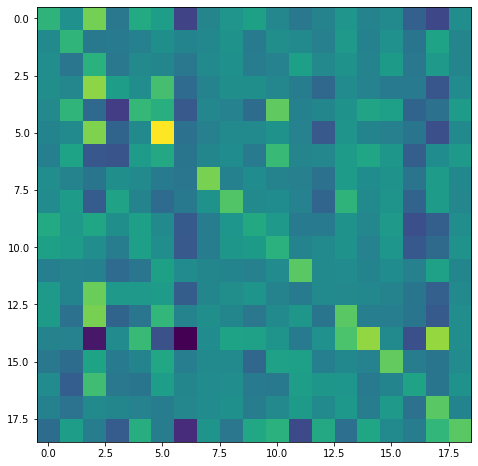

In [100]:
plot_filters(H_ls)

In [101]:
# Least squares postulating it is a graph filter
K = 5
Spow = np.array([np.linalg.matrix_power(A, k) for k in range(K)])
h = cp.Variable(K)
obj = cp.sum_squares(Y_train - cp.sum([h[k] * Spow[k,:,:] for k in range(K)]) @ X_train)
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
h = h.value
H_ls_gf = np.sum([h[k] * Spow[k,:,:] for k in range(K)], 0)

In [102]:
Y_hat_ls_gf = H_ls_gf @ X_test
err_y_ls_gf, err_H_ls_gf = error_metrics(Y_hat_ls_gf, Y_test, H_ls_gf, H_gt)
models.append("Least Squares-GF"); errs_y.append(err_y_ls_gf); errs_H.append(err_H_ls_gf)

Error in signal y: 0.003077991302572691
Error in filter: 0.9784011436614154


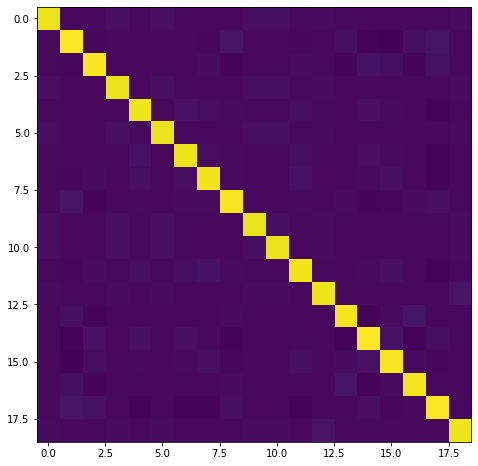

In [103]:
plot_filters(H_ls_gf)

## Iterative (robust) algorithms

In [104]:
args = [0.4, 0.008, 0.0005, 3.]
args = [0., 0., 0., 2.5]
args_no_st = [0.03, 0.005, 0., 3.5]
args_rew = [0.2, 0.1, 0.001, 0.0001, 1.1]
args_rew_no_st = [0.1, 0.08, 0., 5e-4, 1.]

In [105]:
X_norm = (X_train.T - np.mean(X_train.T, axis=0))/np.std(X_train.T, axis=0)

C = np.cov(X_norm.T)

In [106]:
iter, H_iter, S_iter = opt.estH_iter(X, Y, A, C, args)

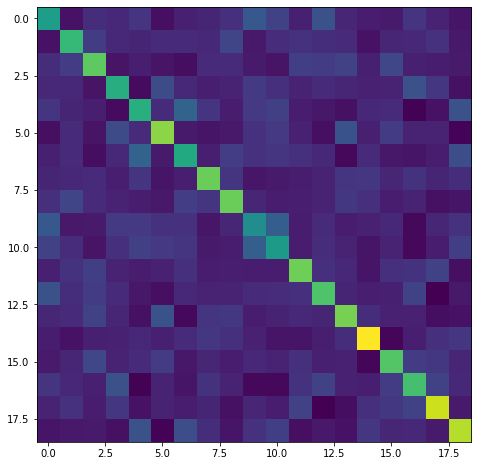

In [107]:
plot_filters(H_iter)

In [108]:
Y_hat_iter = H_iter @ X_test
err_iter, err_H_iter = error_metrics(Y_hat_iter, Y_test, H_iter, H_gt)
models.append("RGFI"); errs_y.append(err_iter); errs_H.append(err_H_iter)

Error in signal y: 0.0027882345974574166
Error in filter: 0.771823774463624


In [109]:
iter, H_iter_rew, S_iter_rew = opt.estH_iter_rew(X, Y, A, C, args_rew)

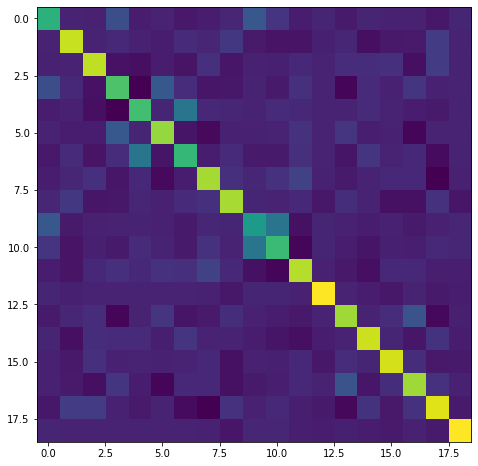

In [110]:
plot_filters(H_iter_rew)

In [111]:
Y_hat_iter_rew = H_iter_rew @ X_test
err_iter_rew, err_H_iter_rew = error_metrics(Y_hat_iter_rew, Y_test, H_iter_rew, H_gt)
models.append("RGFI-REW"); errs_y.append(err_iter_rew); errs_H.append(err_H_iter_rew)

Error in signal y: 0.002964236351749006
Error in filter: 0.8537055545009706


In [112]:
((S_iter - A)**2).sum()

25.700565149809105

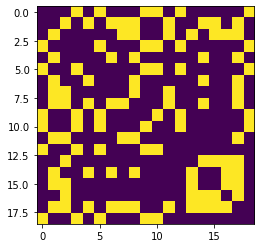

In [113]:
plt.imshow(S_iter)

# Multiple filters ARMA model

In [114]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_test - cp.sum([Hs[p] @ Xs_test[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_gt = np.array([Hs[p].value for p in range(P)])

In [115]:
Y_hat_perf = np.sum(Hs_gt @ Xs_test, 0)
err_mult_per = error_metrics(Y_hat_perf, Y_mult_test)
models.append("VAR-LS-Perfect"); errs_y.append(err_mult_per)

Error in signal y: 0.001937735863137052


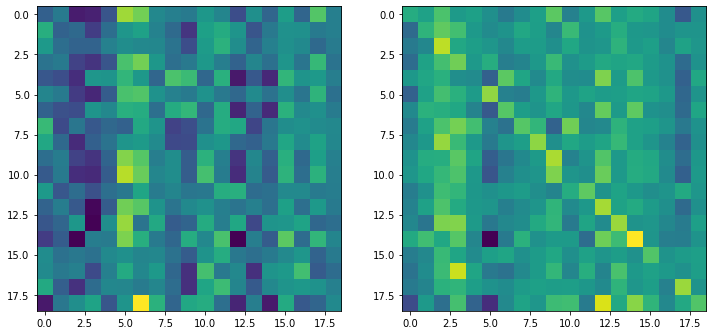

In [116]:
plot_filters(Hs_gt)

## Least squares

In [117]:
Hs = [cp.Variable((N, N)) for _ in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
Hs_ls = np.array([Hs[p].value for p in range(P)])

In [118]:
Y_hat_mult_ls = np.sum(Hs_ls @ Xs_test, 0)
err_mult_ls, err_H_mult_ls = error_metrics(Y_hat_mult_ls, Y_mult_test, Hs_ls, Hs_gt)
models.append("VAR-LS"); errs_y.append(err_mult_ls); errs_H.append(err_H_mult_ls)

Error in signal y: 0.002615652750427505
Error in filter: 0.9013309602848174


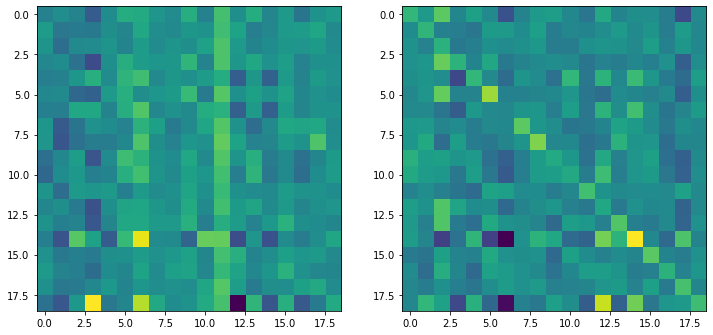

In [119]:
plot_filters(Hs_ls)

In [120]:
# Least squares postulating it is a graph filter
K = 5
hs = [cp.Variable(K) for _ in range(P)]
Hs = [cp.sum([hs[p][k] * Spow[k,:,:] for k in range(K)]) for p in range(P)]
obj = cp.sum_squares(Y_mult_train - cp.sum([Hs[p] @ Xs_train[p,:,:] for p in range(P)]))
prob = cp.Problem(cp.Minimize(obj))
prob.solve()
hs_ls = np.array([hs[p].value for p in range(P)])
Hs_ls_gf = np.array([np.sum([hs_ls[p,k] * Spow[k,:,:] for k in range(5)], 0) for p in range(P)])

In [121]:
Y_hat_mult_ls_gf = np.sum(Hs_ls_gf @ Xs_test, 0)
err_y_mult_ls_gf, err_H_mult_ls_gf = error_metrics(Y_hat_mult_ls_gf, Y_mult_test, Hs_ls_gf, Hs_gt)
models.append("VAR-LS-GF"); errs_y.append(err_y_mult_ls_gf); errs_H.append(err_H_mult_ls_gf)

Error in signal y: 0.0030244167910526793
Error in filter: 0.9658066865367847


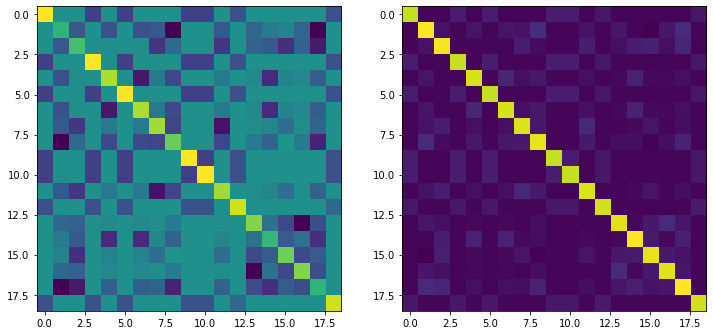

In [122]:
plot_filters(Hs_ls_gf)

## Iterative (robust) algorithms

In [123]:
from robustARMA_opt import estHs_iter, estHs_iter_rew

In [124]:
args = [0.2, 1e-3, 0.02, 1.6]
args_no_st = [0.4, 1e-3, 0., 1.5]
args_rew = [0.07, 1e-3, 0.1, 5e-4, 3.]
args_rew_no_st = [0.02, 1e-4, 0., 5e-4, 2.]

In [125]:
iter, Hs_iter, Ss_iter = estHs_iter(Xs_train, Y_mult_train, A, C, args)

In [126]:
((Ss_iter - A)**2).sum() / norm_A, ((Ss_iter - data['A_bin'])**2).sum() / norm_A

(1.2995338261803786, 1.2995338261803786)

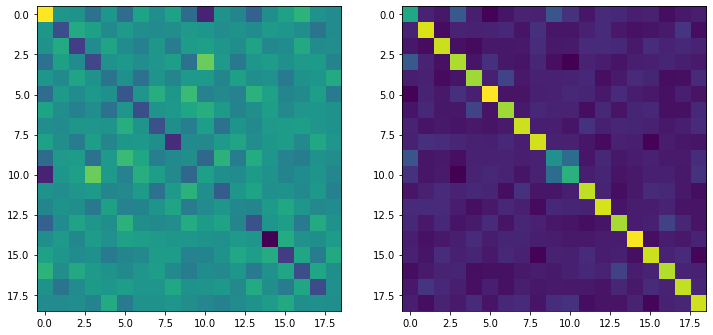

In [127]:
plot_filters(Hs_iter)

In [128]:
Y_hat_mult_iter = np.sum(Hs_iter @ Xs_test, 0)
err_mult_iter, err_Hs_mult_iter = error_metrics(Y_hat_mult_iter, Y_mult_test, Hs_iter, Hs_gt)
models.append("VAR-RGFI"); errs_y.append(err_mult_iter); errs_H.append(err_Hs_mult_iter)

Error in signal y: 0.0028075100853797675
Error in filter: 0.9234539157519333


In [129]:
iter, Hs_iter_rew, Ss_iter_rew = estHs_iter_rew(Xs_train, Y_mult_train, A, C, args_rew)

In [130]:
((Ss_iter_rew - A)**2).sum() / norm_A, ((Ss_iter_rew - data['A_bin'])**2).sum() / norm_A

(2.3175240133387742, 2.3175240133387742)

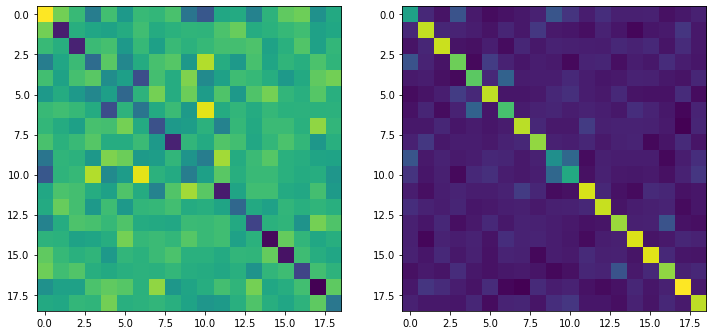

In [131]:
plot_filters(Hs_iter_rew)

In [132]:
Y_hat_mult_iter_rew = np.sum(Hs_iter_rew @ Xs_test, 0)
err_mult_iter_rew, err_Hs_mult_iter_rew = error_metrics(Y_hat_mult_iter_rew, Y_mult_test, Hs_iter_rew, Hs_gt)
models.append("VAR-RGFI-REW"); errs_y.append(err_mult_iter_rew); errs_H.append(err_Hs_mult_iter_rew)

Error in signal y: 0.0028284519792763658
Error in filter: 0.9322897957890546
